In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datascience import *
import math
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [117]:
# Functions

def reformat_dates(data):
    data["Year"] = data.game_id.str[3:7].astype(int)
    data["Month"] = data.game_id.str[7:9].astype(int)
    data["Day"] = data.game_id.str[9:11].astype(int)
    return(data)

def total_bases(s):
    if s[0:1] == "K":
        return(0)
    elif s[0:1] == "W" or s[0:2] == "IW":
        return(1)
    try:
        index = s.index("/")
        arr = ["K", "S", "D", "T", "H"]
        return(arr.index(s[0:1]))
    except ValueError:
        return(0)
    
def play_result(s):
    if s[0:1] == "K":
        return("O")
    elif s[0:1] == "W" or s[0:2] == "IW":
        return("W")  
    if s[0:1] in ["S", "D", "T", "H"]:
        return(s[0:1])
    else:
        return("O")

def after_3_balls(s):
    index = 0
    count = 0
    if "V" in s:
        return("")
    for c in range(len(s)):
        if s[c] == "B":
            index = c
            count = count+1
        if count == 3:
            break
    return(s[index+1:])

def get_first_pitch(s):
    arr = ["C", "S", "B", "X", "F", "T", 'H', "L", "M", "P", "V", "K","Q", "R"]
    for letter in s:
        if letter in arr:
            return(letter)
    return("")

In [3]:
pitching = pd.read_csv('pitching.csv')
info = pd.read_csv('info.csv')
plays = pd.read_csv('plays.csv')
pitching = reformat_dates(pitching)
info = reformat_dates(info)
plays = reformat_dates(plays)


C:\Users\Student\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,8,26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [171]:
modern_plays = plays[plays["Year"] >= 2010][['game_id', 'Year','order', 'pitcher', 'pitch_count', 'inning', 'team',
       'player_id', 'count_on_batter', 'pitch_str', 'play_str', 'B', '1', '2',
       '3', 'H', 'run', 'out','trajectory', 'play_outs']]
modern_plays.tail(5)

,game_id,Year,order,pitcher,pitch_count,inning,team,player_id,count_on_batter,pitch_str,play_str,B,1,2,3,H,run,out,trajectory,play_outs
13260277,WAS201909280,2019,94,matop002,24,8,1,sotoj001,32,S*BS*BBX,7/F,0,1,0,0,0,0,3,F,1
13260278,WAS201909280,2019,98,dools001,3,9,0,zimmb001,11,...CBX,7/L,0,0,0,0,0,0,1,L,1
13260279,WAS201909280,2019,99,dools001,7,9,0,merco003,21,BFBX,9/F,0,0,0,0,0,0,2,F,1
13260280,WAS201909280,2019,100,dools001,17,9,0,luplj001,32,FSFFFFBBBX,HR/7/F,0,0,0,0,1,1,2,F,0
13260281,WAS201909280,2019,102,dools001,21,9,0,flahr001,12,.SBCX,6/P,0,0,0,0,1,1,3,P,1


In [169]:
soto = modern_plays[(modern_plays['player_id'] == 'sotoj001') & (modern_plays['Year'] == 2019)][['game_id', 'Year','order', 'pitcher', 'pitch_count',
       'count_on_batter', 'pitch_str', 'play_str', 'trajectory', 'play_outs']]
soto["balls"] = (soto["count_on_batter"]/10).apply(np.floor)
soto["strikes"] = soto.count_on_batter%10
soto["bases"] = soto["play_str"].apply(total_bases)
soto["result"] = soto["play_str"].apply(play_result)
soto = soto[['game_id', 'Year', 'count_on_batter', 'balls', 'strikes',
       'pitch_str','play_str', 'result','bases']]

soto.head()

,game_id,Year,count_on_batter,balls,strikes,pitch_str,play_str,result,bases
13080750,BAL201907160,2019,22,2,2,CSBBS,K,O,0
13080769,BAL201907160,2019,12,1,2,BFFX,8/F,O,0
13080789,BAL201907160,2019,21,2,1,BFBX,HR/89/F,H,4
13080805,BAL201907160,2019,32,3,2,FBBBSX,8/F+,O,0
13080823,BAL201907160,2019,21,2,1,BBCX,S7/G+.2-H;1-2,S,1


In [170]:
#How do pitchers handle Juan Soto with 3 balls?
soto_late_count = soto[soto["balls"] == 3]
soto_late_count["ball_3_pitch_str"] = soto_late_count["pitch_str"].apply(after_3_balls)
soto_late_count.head()

<ipython-input-170-2464df24a4d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soto_late_count["ball_3_pitch_str"] = soto_late_count["pitch_str"].apply(after_3_balls)


,game_id,Year,count_on_batter,balls,strikes,pitch_str,play_str,result,bases,ball_3_pitch_str
13080805,BAL201907160,2019,32,3,2,FBBBSX,8/F+,O,0,SX
13080836,BAL201907170,2019,31,3,1,BBBCB,W,W,1,CB
13080850,BAL201907170,2019,32,3,2,.BFCFBBX,8/L,O,0,X
13080871,BAL201907170,2019,32,3,2,BCBBCX,31/G,O,0,CX
13080891,BAL201907170,2019,31,3,1,BBBCB,W.1-2,W,1,CB


In [7]:
#Batting average with 3 balls
hits_3_balls = len(soto_late_count[(soto_late_count["result"] != "W") & (soto_late_count["result"] != "O")])
outs_3_balls = len(soto_late_count[soto_late_count["result"] == "O"])
walks_3_balls = len(soto_late_count[soto_late_count["result"] == "W"])
n_3_balls = walks_3_balls + outs_3_balls + hits_3_balls
print(len(soto_late_count), " Observations")
print("Soto's Average with 3 balls: ", hits_3_balls / outs_3_balls)
print("Soto's Hit or Walk % with 3 balls: ", (walks_3_balls + hits_3_balls) / n_3_balls)
print("Hit%: ", hits_3_balls/n_3_balls, "\tWalk%: ", walks_3_balls/n_3_balls, "\tOut%: ", outs_3_balls/n_3_balls)

232  Observations
Soto's Average with 3 balls:  0.3368421052631579
Soto's Hit or Walk % with 3 balls:  0.5905172413793104
Hit%:  0.13793103448275862 	Walk%:  0.4525862068965517 	Out%:  0.40948275862068967


In [12]:
#Batting average with 3 balls by count
def summarize_hwo(df, count):
    h = hits_3_balls = len(df[(df["result"] != "W") & (df["result"] != "O")])
    o = len(df[df["result"] == "O"])
    w = len(df[df["result"] == "W"])
    n = h+o+w
    print(n, " Observations\n",
          "Average with ", count, " count: ", h / (h+o), "\n",
          "Hit or walk % with ", count, " count: ", (h+w)/n, "\n",
          "Hit%: ",h/n, " Walk%:", w/n, " Out%:", o/n)
    
summarize_hwo(soto_late_count[soto_late_count["count_on_batter"] == 32], "3-2")
summarize_hwo(soto_late_count[soto_late_count["count_on_batter"] == 31], "3-1")
summarize_hwo(soto_late_count[soto_late_count["count_on_batter"] == 30], "3-0")

166  Observations
 Average with  3-2  count:  0.23478260869565218 
 Hit or walk % with  3-2  count:  0.46987951807228917 
 Hit%:  0.16265060240963855  Walk%: 0.3072289156626506  Out%: 0.5301204819277109
46  Observations
 Average with  3-1  count:  0.4 
 Hit or walk % with  3-1  count:  0.8695652173913043 
 Hit%:  0.08695652173913043  Walk%: 0.782608695652174  Out%: 0.13043478260869565
20  Observations
 Average with  3-0  count:  0.5 
 Hit or walk % with  3-0  count:  0.95 
 Hit%:  0.05  Walk%: 0.9  Out%: 0.05


In [26]:
#Find League Average for these values
no_soto = modern_plays[(modern_plays['player_id'] != 'sotoj001') & (modern_plays['Year'] == 2019)][['game_id', 'Year',
       'count_on_batter', 'pitch_str', 'play_str']]
no_soto["balls"] = (no_soto["count_on_batter"]/10).apply(np.floor)
no_soto["strikes"] = no_soto.count_on_batter%10
no_soto["bases"] = no_soto["play_str"].apply(total_bases)
no_soto["result"] = no_soto["play_str"].apply(play_result)
no_soto = no_soto[['game_id', 'Year', 'count_on_batter', 'balls', 'strikes',
       'pitch_str','play_str', 'result','bases']]

summarize_hwo(no_soto[no_soto["count_on_batter"] == 32], "3-2")
summarize_hwo(no_soto[no_soto["count_on_batter"] == 31], "3-1")
summarize_hwo(no_soto[no_soto["count_on_batter"] == 30], "3-0")


26229  Observations
 Average with  3-2  count:  0.2039980065341381 
 Hit or walk % with  3-2  count:  0.4519425063860612 
 Hit%:  0.14045522131991306  Walk%: 0.31148728506614815  Out%: 0.5480574936139387
7903  Observations
 Average with  3-1  count:  0.36650082918739635 
 Hit or walk % with  3-1  count:  0.7099835505504238 
 Hit%:  0.16778438567632545  Walk%: 0.5421991648740985  Out%: 0.2900164494495761
3544  Observations
 Average with  3-0  count:  0.422279792746114 
 Hit or walk % with  3-0  count:  0.9370767494356659 
 Hit%:  0.04599322799097066  Walk%: 0.8910835214446953  Out%: 0.06292325056433408


In [48]:
#Breakdown of pitches thrown right after the count gets to 3 balls
after_3b_soto = soto_late_count[['count_on_batter', 'balls', 'strikes', 'pitch_str',"ball_3_pitch_str", 'result','bases']]
def next_filter(s):
    a = s[0:1]
    arr = ["*", " ", "."]
    if a in arr:
        return(s[1:2])
    return(a)
after_3b_soto["next_pitch"] = after_3b_soto["ball_3_pitch_str"].apply(next_filter)
after_3b_soto["next_pitch"].value_counts()

<ipython-input-48-060cf3afa052>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_3b_soto["next_pitch"] = after_3b_soto["ball_3_pitch_str"].apply(next_filter)


B    60
X    50
F    47
C    40
S    26
1     3
T     3
      3
Name: next_pitch, dtype: int64

In [172]:
#Want to see what happens as soon as the count gets to 3 balls with juan soto
after_3b_soto.head(10)
def strikes_at_3_balls(s):
    arr = ["C", "S", "F", "K", "T"]
    count = 0
    b_count = 0
    for p in s:
        if p in arr:
            count = count+1
        elif p == "B":
            b_count = b_count+1
        if b_count == 3:
            break
    if count > 2:
        return(2)
    else:
        return(count)

after_3b_soto["strikes_at_ball_3"] = after_3b_soto["pitch_str"].apply(strikes_at_3_balls)
no_soto["strikes_at_ball_3"] = no_soto["pitch_str"].apply(strikes_at_3_balls)
after_3b_soto.head(5)


,count_on_batter,balls,strikes,pitch_str,ball_3_pitch_str,result,bases,next_pitch,strikes_at_ball_3
13080805,32,3,2,FBBBSX,SX,O,0,S,1
13080836,31,3,1,BBBCB,CB,W,1,C,0
13080850,32,3,2,.BFCFBBX,X,O,0,X,2
13080871,32,3,2,BCBBCX,CX,O,0,C,1
13080891,31,3,1,BBBCB,CB,W,1,C,0


In [73]:
def expected_bases(df, strikes_ball3):
    return(np.mean(df[df["strikes_at_ball_3"] == strikes_ball3]["bases"]))

In [164]:
exp_bases_data = [['0', expected_bases(after_3b_soto, 0), expected_bases(no_soto, 0)],
                  ['1', expected_bases(after_3b_soto, 1), expected_bases(no_soto, 1)],
                  ['2', expected_bases(after_3b_soto, 2), expected_bases(no_soto, 2)]]
exp_bases = pd.DataFrame(exp_bases_data, columns=["Strikes at Ball 3", "Soto EB", "Rest of League EB"])
exp_bases["Difference"] = exp_bases["Soto EB"] - exp_bases["Rest of League EB"]
exp_bases["%Diff"] = 100* exp_bases["Difference"] / exp_bases["Rest of League EB"]
exp_bases

,Strikes at Ball 3,Soto EB,Rest of League EB,Difference,%Diff
0,0,0.977778,0.639682,0.338096,52.853707
1,1,0.835821,0.578166,0.257655,44.564264
2,2,0.550000,0.322706,0.227294,70.433842


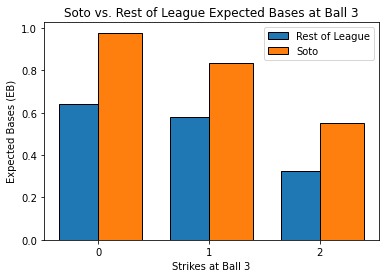

In [99]:
bar_width = 0.4
plt.bar(np.arange(3), exp_bases["Rest of League EB"], bar_width, label="Rest of League")
plt.bar(np.arange(3)+0.35, exp_bases["Soto EB"], bar_width, label="Soto")
plt.xlabel("Strikes at Ball 3")
plt.ylabel("Expected Bases (EB)")
plt.title("Soto vs. Rest of League Expected Bases at Ball 3")
plt.xticks(np.arange(3)+0.15, ('0', '1', '2'))
plt.legend()

In [114]:
#Important to throw strikes to Soto
#Soto forces pitchers to put the ball in the strikezone early in the count
soto_walk_rate = len(soto[soto['result'] == "W"]) / len(soto) * 100
plays_2019 = modern_plays[(modern_plays['player_id'] != 'sotoj001') & (modern_plays['Year'] == 2019)][['game_id', 'Year',
       'count_on_batter', 'pitch_str', 'play_str']]
plays_2019['result'] = plays_2019['play_str'].apply(play_result)
rol_walk_rate = len(plays_2019[plays_2019['result'] == "W"]) / len(plays_2019) * 100

print("Soto Walk Rate:          ", round(soto_walk_rate, 2), "%")
print("Rest of League Walk Rate: ", round(rol_walk_rate, 2), "%")

Soto Walk Rate:           16.17 %
Rest of League Walk Rate:  9.12 %


In [143]:
#What does Soto do on the first pitch?
soto['first_pitch'] = soto['pitch_str'].apply(get_first_pitch)
soto_abs = len(soto)
no_swing = len(soto[(soto['first_pitch'] == "B") | (soto['first_pitch'] == "C") | (soto['first_pitch'] == "H")])
print("Soto Doesn't Swing ", 100*no_swing/soto_abs, "% of the time")
plays_2019['first_pitch'] = plays_2019['pitch_str'].apply(get_first_pitch)
no_swing_league = len(plays_2019[(plays_2019['first_pitch'] == "B") | (plays_2019['first_pitch'] == "C") | (plays_2019['first_pitch'] == "H")])
print("League Doesn't Swing ", 100*no_swing_league/len(plays_2019), "% of the time")

Soto Doesn't Swing  70.77151335311572 % of the time
League Doesn't Swing  69.96223061541879 % of the time


In [145]:
soto_first_pitch_take = soto[(soto['first_pitch'] == "B") | (soto['first_pitch'] == "C") | (soto['first_pitch'] == "H")]
league_first_pitch_take = plays_2019[(plays_2019['first_pitch'] == "B") | (plays_2019['first_pitch'] == "C") | (plays_2019['first_pitch'] == "H")]
soto_takes = soto_first_pitch_take['first_pitch'].value_counts()
league_takes = league_first_pitch_take['first_pitch'].value_counts()

print("Soto First Pitch Ball Rate: ", 100*soto_takes["B"] / sum(soto_takes), "%")
print("League First Pitch Ball Rate: ", 100*league_takes["B"] / sum(league_takes), "%")

Soto First Pitch Ball Rate:  63.312368972746334 %
League First Pitch Ball Rate:  55.50439292897216 %


In [147]:
#Compare soto first pitch average to league

14.067311850011373

In [155]:
soto_fp_contact = soto[soto['first_pitch'] == "X"]
legaue_fp_contact = plays_2019[plays_2019['first_pitch'] == "X"]
s_counts = soto_fp_contact['result'].value_counts()
l_counts = legaue_fp_contact['result'].value_counts()
print("Soto First pitch Average: ", round((sum(s_counts) - s_counts["O"])/sum(s_counts), 3))
print("League First pitch Average: ", round((sum(l_counts) - l_counts["O"])/sum(l_counts), 3))

Soto First pitch Average:  0.437
League First pitch Average:  0.344
